In [3]:
import sys
import os
import re
from typing import List

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [6]:
from config import settings as config

In [7]:
from src.data_processing.loading import load_data
from src.data_processing.transformation import date_format_change, extract_month_from_date
from src.data_processing.cleaning import clean_name, drop_columns
from src.data_processing.transformation import filter_by_state, filter_df_by_level
from src.data_processing.validation import (
    get_dominant_district_per_pincode, 
    flag_multi_district_pincodes, 
    unique_pincode_count, 
    get_pin_district_count, 
    flag_problematic_enrolments, 
    aggregate_enrolments_by_district_pincode,
)

Importing Demographic Data Files

In [8]:
from typing import List
def load_data(file_paths : List[str]) -> pd.DataFrame:
    dfs = [] # List to hold individual DataFrames
    
    for file_path in file_paths:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
        
        print("*"*50)
        
        print(f"Loading file: {file_path}...")

        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
            print(f"Successfully loaded {file_path} with shape {df.shape}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            raise

    if not dfs:
        return pd.DataFrame()  # Return empty DataFrame
    
    combined_df = pd.concat(dfs, axis=0, ignore_index=True)
    print("*"*50)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    return combined_df


In [9]:
demographic_df = load_data(config.DEMOGRAPHIC_DATA_PATHS)

**************************************************
Loading file: c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_demographic\api_data_aadhar_demographic_0_500000.csv...
Successfully loaded c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_demographic\api_data_aadhar_demographic_0_500000.csv with shape (500000, 6)
**************************************************
Loading file: c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_demographic\api_data_aadhar_demographic_500000_1000000.csv...
Successfully loaded c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_demographic\api_data_aadhar_demographic_500000_1000000.csv with shape (500000, 6)
**************************************************
Loading file: c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_demographic\api_data_aadhar_demographic_1000000_1500000.csv...
Successfully loaded c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_demographic\api_data_aadhar_demographic_1000000_1500000.csv with shape (500000, 6)
*****

In [10]:
print("Demographic DataFrame:")
demographic_df.head(10)

Demographic DataFrame:


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785
5,01-03-2025,Rajasthan,Sikar,332028,28,285
6,01-03-2025,Karnataka,Tumakuru,572201,88,332
7,01-03-2025,Uttar Pradesh,Gorakhpur,273211,61,836
8,01-03-2025,Andhra Pradesh,Kurnool,518313,83,986
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281


In [11]:
date_format_change(demographic_df, 'date_changed').head(10)

,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529,20250301
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375,20250301
2,01-03-2025,Gujarat,Rajkot,360006,65,765,20250301
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314,20250301
4,01-03-2025,Rajasthan,Udaipur,313801,45,785,20250301
5,01-03-2025,Rajasthan,Sikar,332028,28,285,20250301
6,01-03-2025,Karnataka,Tumakuru,572201,88,332,20250301
7,01-03-2025,Uttar Pradesh,Gorakhpur,273211,61,836,20250301
8,01-03-2025,Andhra Pradesh,Kurnool,518313,83,986,20250301
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,20250301


In [12]:
demographic_df['date_changed'].isnull().sum()

0

In [13]:
demographic_df['state'].unique()

array(['Uttar Pradesh', 'Andhra Pradesh', 'Gujarat', 'Rajasthan',
       'Karnataka', 'West Bengal', 'Telangana', 'Odisha', 'Maharashtra',
       'Kerala', 'Bihar', 'Tamil Nadu', 'Madhya Pradesh', 'Assam',
       'Tripura', 'Arunachal Pradesh', 'Punjab', 'Jharkhand', 'Delhi',
       'Chandigarh', 'Chhattisgarh', 'Jammu and Kashmir', 'Mizoram',
       'Nagaland', 'Himachal Pradesh', 'Goa', 'Haryana', 'Meghalaya',
       'Uttarakhand', 'Manipur', 'Daman and Diu', 'Puducherry', 'Sikkim',
       'Ladakh', 'Dadra and Nagar Haveli and Daman and Diu',
       'Dadra and Nagar Haveli', 'Orissa', 'Pondicherry',
       'Andaman & Nicobar Islands', 'Andaman and Nicobar Islands',
       'west Bengal', 'Daman & Diu', 'West  Bengal', 'odisha',
       'Jammu & Kashmir', 'Lakshadweep', 'Dadra & Nagar Haveli',
       'Westbengal', 'andhra pradesh', 'WEST BENGAL', 'West Bangal',
       'West bengal', 'ODISHA', 'WESTBENGAL', 'Chhatisgarh',
       'West Bengli', 'Darbhanga', 'Puttenahalli', 'BALANAGAR',
  

In [14]:
demographic_df['state'].nunique()

65

TODO: Use LLM To Generate Content For This Section

In [15]:
demographic_df.drop(demographic_df[demographic_df['state'] == '100000'].index, inplace=True)
demographic_df['state'] = demographic_df['state'].replace('Darbhanga', 'Bihar')
demographic_df['state'] = demographic_df['state'].replace('Puttenahalli', 'Karnataka')
demographic_df['state'] = demographic_df['state'].replace('BALANAGAR', 'Telangana')
demographic_df['state'] = demographic_df['state'].replace('Uttaranchal', 'Uttarakhand')
demographic_df['state'] = demographic_df['state'].replace('Jaipur', 'Rajasthan')
demographic_df['state'] = demographic_df['state'].replace('Madanapalle', 'Andhra Pradesh')
demographic_df['state'] = demographic_df['state'].replace('Nagpur', 'Maharashtra')
demographic_df['state'] = demographic_df['state'].replace('Raja Annamalai Puram', 'Tamil Nadu')

In [16]:
# Mapping dictionary for state name corrections
STATE_MAPPING = {
    # Andaman and Nicobar Islands
    'andaman and nicobar islands': 'Andaman and Nicobar Islands',
    'andaman nicobar islands': 'Andaman and Nicobar Islands',
    
    # Andhra Pradesh
    'andhra pradesh': 'Andhra Pradesh',
    
    # Arunachal Pradesh
    'arunachal pradesh': 'Arunachal Pradesh',
    
    # Assam
    'assam': 'Assam',
    
    # Bihar
    'bihar': 'Bihar',
    
    # Chandigarh
    'chandigarh': 'Chandigarh',
    
    # Chhattisgarh
    'chhattisgarh': 'Chhattisgarh',
    'chhatisgarh' : 'Chhattisgarh',
    
    # Dadra and Nagar Haveli and Daman and Diu
    'dadra nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli and daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'the dadra and nagar haveli and daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'daman diu': 'Dadra and Nagar Haveli and Daman and Diu',
    
    # Delhi
    'delhi': 'Delhi',
    
    # Goa
    'goa': 'Goa',
    
    # Gujarat
    'gujarat': 'Gujarat',
    
    # Haryana
    'haryana': 'Haryana',
    
    # Himachal Pradesh
    'himachal pradesh': 'Himachal Pradesh',
    
    # Jammu and Kashmir
    'jammu and kashmir': 'Jammu and Kashmir',
    'jammu kashmir': 'Jammu and Kashmir',
    
    # Jharkhand
    'jharkhand': 'Jharkhand',
    
    # Karnataka
    'karnataka': 'Karnataka',
    
    # Kerala
    'kerala': 'Kerala',
    
    # Ladakh
    'ladakh': 'Ladakh',
    
    # Lakshadweep
    'lakshadweep': 'Lakshadweep',
    
    # Madhya Pradesh
    'madhya pradesh': 'Madhya Pradesh',
    
    # Maharashtra
    'maharashtra': 'Maharashtra',
    
    # Manipur
    'manipur': 'Manipur',
    
    # Meghalaya
    'meghalaya': 'Meghalaya',
    
    # Mizoram
    'mizoram': 'Mizoram',
    
    # Nagaland
    'nagaland': 'Nagaland',
    
    # Odisha
    'odisha': 'Odisha',
    'orissa': 'Odisha',
    
    # Puducherry
    'puducherry': 'Puducherry',
    'pondicherry': 'Puducherry',
    
    # Punjab
    'punjab': 'Punjab',
    
    # Rajasthan
    'rajasthan': 'Rajasthan',
    
    # Sikkim
    'sikkim': 'Sikkim',
    
    # Tamil Nadu
    'tamil nadu': 'Tamil Nadu',
    
    # Telangana
    'telangana': 'Telangana',
    
    # Tripura
    'tripura': 'Tripura',
    
    # Uttar Pradesh
    'uttar pradesh': 'Uttar Pradesh',
    
    # Uttarakhand
    'uttarakhand': 'Uttarakhand',
    
    # West Bengal
    'west bengal': 'West Bengal',
    'west bangal': 'West Bengal',
    'westbengal': 'West Bengal',
    'west  bengal': 'West Bengal',
    'westbengal ': 'West Bengal',
    'west bengli':  'West Bengal',
}

In [17]:
clean_name(demographic_df, 'state', STATE_MAPPING, 'state_cleaned').head(10)

,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed,state_cleaned
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529,20250301,Uttar Pradesh
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375,20250301,Andhra Pradesh
2,01-03-2025,Gujarat,Rajkot,360006,65,765,20250301,Gujarat
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314,20250301,Andhra Pradesh
4,01-03-2025,Rajasthan,Udaipur,313801,45,785,20250301,Rajasthan
5,01-03-2025,Rajasthan,Sikar,332028,28,285,20250301,Rajasthan
6,01-03-2025,Karnataka,Tumakuru,572201,88,332,20250301,Karnataka
7,01-03-2025,Uttar Pradesh,Gorakhpur,273211,61,836,20250301,Uttar Pradesh
8,01-03-2025,Andhra Pradesh,Kurnool,518313,83,986,20250301,Andhra Pradesh
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,20250301,West Bengal


In [18]:
# Drop invalid entries like numeric junk
demographic_df = demographic_df[~demographic_df['state'].astype(str).str.isnumeric()]

# Check unmapped states
unmapped = demographic_df[demographic_df['state_cleaned'].isna()]['state'].unique()
print("Unmapped values:", unmapped)


Unmapped values: []


In [19]:
demographic_df['state_cleaned'].unique()

array(['Uttar Pradesh', 'Andhra Pradesh', 'Gujarat', 'Rajasthan',
       'Karnataka', 'West Bengal', 'Telangana', 'Odisha', 'Maharashtra',
       'Kerala', 'Bihar', 'Tamil Nadu', 'Madhya Pradesh', 'Assam',
       'Tripura', 'Arunachal Pradesh', 'Punjab', 'Jharkhand', 'Delhi',
       'Chandigarh', 'Chhattisgarh', 'Jammu and Kashmir', 'Mizoram',
       'Nagaland', 'Himachal Pradesh', 'Goa', 'Haryana', 'Meghalaya',
       'Uttarakhand', 'Manipur',
       'Dadra and Nagar Haveli and Daman and Diu', 'Puducherry', 'Sikkim',
       'Ladakh', 'Andaman and Nicobar Islands', 'Lakshadweep'],
      dtype=object)

In [20]:
demographic_df['state_cleaned'].nunique()

36

In [21]:
wb_demographic_df = filter_by_state(demographic_df, 'West Bengal')

In [22]:
wb_demographic_df.head(10)

,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed,state_cleaned
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,20250301,West Bengal
40,01-03-2025,West Bengal,Howrah,711303,118,1909,20250301,West Bengal
50,01-03-2025,West Bengal,Paschim Medinipur,721436,10,168,20250301,West Bengal
59,01-03-2025,West Bengal,Hooghly,712148,35,639,20250301,West Bengal
87,01-03-2025,West Bengal,Paschim Bardhaman,713213,10,201,20250301,West Bengal
99,01-03-2025,West Bengal,Puruliya,723151,34,490,20250301,West Bengal
104,01-03-2025,West Bengal,South 24 Parganas,743337,90,1822,20250301,West Bengal
113,01-03-2025,West Bengal,Hooghly,712406,43,664,20250301,West Bengal
159,01-03-2025,West Bengal,Purba Medinipur,721429,29,364,20250301,West Bengal
160,01-03-2025,West Bengal,North 24 Parganas,743222,16,398,20250301,West Bengal


In [23]:
clean_name(wb_demographic_df, 'district', config.DISTRICT_MAPPING_WB, 'district_cleaned').head(10)

c:\Users\sahab\Desktop\uidi\src\data_processing\cleaning.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cleaned_column_name] = cleaned.map(name_mapping).fillna(df[column_name])


,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed,state_cleaned,district_cleaned
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,20250301,West Bengal,Paschim Medinipur
40,01-03-2025,West Bengal,Howrah,711303,118,1909,20250301,West Bengal,Howrah
50,01-03-2025,West Bengal,Paschim Medinipur,721436,10,168,20250301,West Bengal,Paschim Medinipur
59,01-03-2025,West Bengal,Hooghly,712148,35,639,20250301,West Bengal,Hooghly
87,01-03-2025,West Bengal,Paschim Bardhaman,713213,10,201,20250301,West Bengal,Paschim Bardhaman
99,01-03-2025,West Bengal,Puruliya,723151,34,490,20250301,West Bengal,Purulia
104,01-03-2025,West Bengal,South 24 Parganas,743337,90,1822,20250301,West Bengal,South 24 Parganas
113,01-03-2025,West Bengal,Hooghly,712406,43,664,20250301,West Bengal,Hooghly
159,01-03-2025,West Bengal,Purba Medinipur,721429,29,364,20250301,West Bengal,Purba Medinipur
160,01-03-2025,West Bengal,North 24 Parganas,743222,16,398,20250301,West Bengal,North 24 Parganas


In [24]:
wb_demographic_df['district_cleaned'].nunique()

28

In [25]:
wb_demographic_df['district_cleaned'] = wb_demographic_df['district_cleaned'].replace({
    '24 Paraganas North': 'North 24 Parganas',
    '24 Paraganas South': 'South 24 Parganas'
})

C:\Users\sahab\AppData\Local\Temp\ipykernel_11576\2600096831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb_demographic_df['district_cleaned'] = wb_demographic_df['district_cleaned'].replace({


In [26]:
wb_demographic_df = wb_demographic_df[~wb_demographic_df['state'].astype(str).str.isnumeric()]

In [27]:
wb_demographic_df['district_cleaned'].unique()

array(['Paschim Medinipur', 'Howrah', 'Hooghly', 'Paschim Bardhaman',
       'Purulia', 'South 24 Parganas', 'Purba Medinipur',
       'North 24 Parganas', 'Nadia', 'Murshidabad', 'Kolkata', 'Bankura',
       'Purba Bardhaman', 'Jalpaiguri', 'Uttar Dinajpur', 'Darjeeling',
       'Birbhum', 'Malda', 'Kalimpong', 'Jhargram', 'Cooch Behar',
       'Dakshin Dinajpur', 'Alipurduar', 'Medinipur', 'South DumDum(M)',
       'Bally Jagachha', 'Domjur', 'Naihati Anandabazar'], dtype=object)

In [28]:
unique_pincode_count(wb_demographic_df)

,district_cleaned,unique_pincode_count
0,Alipurduar,27
1,Bally Jagachha,1
2,Bankura,85
3,Birbhum,55
4,Cooch Behar,57
5,Dakshin Dinajpur,29
6,Darjeeling,70
7,Domjur,1
8,Hooghly,111
9,Howrah,60


In [29]:
pin_district_count = get_pin_district_count(wb_demographic_df)
pin_district_count

,pincode,district_count
0,700001,1
1,700002,1
2,700003,1
3,700004,1
4,700005,1
...,...,...
1359,743702,1
1360,743704,1
1361,743710,1
1362,743711,2


In [30]:
problem_pins = pin_district_count[
    pin_district_count['district_count'] > 1
]

In [31]:
enrolment_flagged = flag_problematic_enrolments(wb_demographic_df, problem_pins)

In [32]:
enrolment_flagged

,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed,state_cleaned,district_cleaned
0,01-03-2025,West Bengal,Paschim Medinipur,721436,10,168,20250301,West Bengal,Paschim Medinipur
1,01-03-2025,West Bengal,Paschim Bardhaman,713213,10,201,20250301,West Bengal,Paschim Bardhaman
2,01-03-2025,West Bengal,Purba Medinipur,721429,29,364,20250301,West Bengal,Purba Medinipur
3,01-03-2025,West Bengal,Hooghly,712301,11,248,20250301,West Bengal,Hooghly
4,01-03-2025,West Bengal,Murshidabad,742202,230,3147,20250301,West Bengal,Murshidabad
...,...,...,...,...,...,...,...,...,...
65163,29-12-2025,West Bengal,West Midnapore,721124,0,1,20251229,West Bengal,Paschim Medinipur
65164,29-12-2025,West Bengal,West Midnapore,721150,1,9,20251229,West Bengal,Paschim Medinipur
65165,29-12-2025,West Bengal,West Midnapore,721212,0,12,20251229,West Bengal,Paschim Medinipur
65166,29-12-2025,West Bengal,West Midnapore,721420,0,1,20251229,West Bengal,Paschim Medinipur


In [33]:
flagged_pincode_dominant = aggregate_enrolments_by_district_pincode(
    flag_problematic_enrolments(wb_demographic_df, problem_pins), ['demo_age_5_17', 'demo_age_17_'])
flagged_pincode_dominant.head(10)

,district_cleaned,pincode,demo_age_5_17,demo_age_17_
0,Alipurduar,735204,246,1139
1,Alipurduar,735208,8,91
2,Alipurduar,735210,0,1
3,Alipurduar,735211,110,1215
4,Alipurduar,735213,44,244
5,Alipurduar,735214,17,187
6,Alipurduar,735215,15,125
7,Alipurduar,735216,35,247
8,Alipurduar,735217,57,307
9,Alipurduar,735220,140,624


In [34]:
wb_demographic_df = flag_multi_district_pincodes(wb_demographic_df)

In [35]:
wb_demographic_df

,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed,state_cleaned,district_cleaned,pin_multi_district_flag
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,20250301,West Bengal,Paschim Medinipur,False
40,01-03-2025,West Bengal,Howrah,711303,118,1909,20250301,West Bengal,Howrah,False
50,01-03-2025,West Bengal,Paschim Medinipur,721436,10,168,20250301,West Bengal,Paschim Medinipur,True
59,01-03-2025,West Bengal,Hooghly,712148,35,639,20250301,West Bengal,Hooghly,False
87,01-03-2025,West Bengal,Paschim Bardhaman,713213,10,201,20250301,West Bengal,Paschim Bardhaman,True
...,...,...,...,...,...,...,...,...,...,...
2071695,29-12-2025,West Bengal,West Midnapore,721212,0,12,20251229,West Bengal,Paschim Medinipur,True
2071696,29-12-2025,West Bengal,West Midnapore,721420,0,1,20251229,West Bengal,Paschim Medinipur,True
2071697,29-12-2025,West Bengal,West Midnapore,721424,0,5,20251229,West Bengal,Paschim Medinipur,False
2071698,29-12-2025,West Bengal,West Midnapore,721426,0,3,20251229,West Bengal,Paschim Medinipur,True


In [36]:
wb_demographic_df['total_enroll']=wb_demographic_df['demo_age_5_17']+wb_demographic_df['demo_age_17_']
wb_demographic_df

,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed,state_cleaned,district_cleaned,pin_multi_district_flag,total_enroll
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,20250301,West Bengal,Paschim Medinipur,False,294
40,01-03-2025,West Bengal,Howrah,711303,118,1909,20250301,West Bengal,Howrah,False,2027
50,01-03-2025,West Bengal,Paschim Medinipur,721436,10,168,20250301,West Bengal,Paschim Medinipur,True,178
59,01-03-2025,West Bengal,Hooghly,712148,35,639,20250301,West Bengal,Hooghly,False,674
87,01-03-2025,West Bengal,Paschim Bardhaman,713213,10,201,20250301,West Bengal,Paschim Bardhaman,True,211
...,...,...,...,...,...,...,...,...,...,...,...
2071695,29-12-2025,West Bengal,West Midnapore,721212,0,12,20251229,West Bengal,Paschim Medinipur,True,12
2071696,29-12-2025,West Bengal,West Midnapore,721420,0,1,20251229,West Bengal,Paschim Medinipur,True,1
2071697,29-12-2025,West Bengal,West Midnapore,721424,0,5,20251229,West Bengal,Paschim Medinipur,False,5
2071698,29-12-2025,West Bengal,West Midnapore,721426,0,3,20251229,West Bengal,Paschim Medinipur,True,3


In [37]:
extract_month_from_date(wb_demographic_df, 'date_changed').head(10)

,date,state,district,pincode,demo_age_5_17,demo_age_17_,date_changed,state_cleaned,district_cleaned,pin_multi_district_flag,total_enroll,month
9,01-03-2025,West Bengal,Paschim Medinipur,721148,13,281,20250301,West Bengal,Paschim Medinipur,False,294,03
40,01-03-2025,West Bengal,Howrah,711303,118,1909,20250301,West Bengal,Howrah,False,2027,03
50,01-03-2025,West Bengal,Paschim Medinipur,721436,10,168,20250301,West Bengal,Paschim Medinipur,True,178,03
59,01-03-2025,West Bengal,Hooghly,712148,35,639,20250301,West Bengal,Hooghly,False,674,03
87,01-03-2025,West Bengal,Paschim Bardhaman,713213,10,201,20250301,West Bengal,Paschim Bardhaman,True,211,03
99,01-03-2025,West Bengal,Puruliya,723151,34,490,20250301,West Bengal,Purulia,False,524,03
104,01-03-2025,West Bengal,South 24 Parganas,743337,90,1822,20250301,West Bengal,South 24 Parganas,False,1912,03
113,01-03-2025,West Bengal,Hooghly,712406,43,664,20250301,West Bengal,Hooghly,False,707,03
159,01-03-2025,West Bengal,Purba Medinipur,721429,29,364,20250301,West Bengal,Purba Medinipur,True,393,03
160,01-03-2025,West Bengal,North 24 Parganas,743222,16,398,20250301,West Bengal,North 24 Parganas,False,414,03


In [38]:
wb_demographic_df_month_level = filter_df_by_level(wb_demographic_df, 'month', ['demo_age_5_17', 'demo_age_17_', 'total_enroll'])

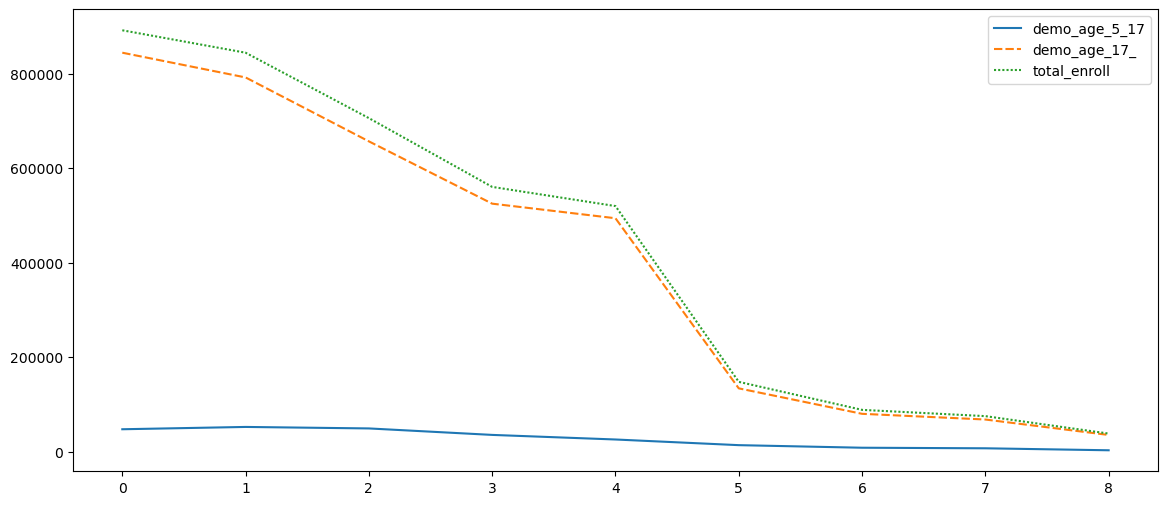

In [39]:
plt.figure(figsize=(14, 6))   # width, height in inches
sns.lineplot(data= wb_demographic_df_month_level[['demo_age_5_17','demo_age_17_','total_enroll']])
plt.show()

In [40]:
wb_demographic_df_month_level.to_excel("wb_demographic_df_month_level.xlsx") 